---

# Decline of the urban forest in San Jose, California as seen through change in NDVI


> Image source: 

## STEP 1: SET UP

In [36]:
pip install geoviews

  Obtaining dependency information for geoviews from https://files.pythonhosted.org/packages/7c/b1/c27b294bc3bfc06d7721082568f53d076918a039864afc656d6d237fe08b/geoviews-1.10.1-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.8/509.8 kB 9.2 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install git+https://github.com/earthlab/earthpy@apppears

  Cloning https://github.com/earthlab/earthpy (to revision apppears) to /tmp/pip-req-build-rdglrwrg
  Running command git clone --filter=blob:none --quiet https://github.com/earthlab/earthpy /tmp/pip-req-build-rdglrwrg
  Running command git checkout -b apppears --track origin/apppears
  Switched to a new branch 'apppears'
  Branch 'apppears' set up to track remote branch 'apppears' from 'origin'.
  Resolved https://github.com/earthlab/earthpy to commit ae32522290f89a46e8b87639865b22561ae403db
  Installing build dependencies ... 

done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [37]:
import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import geoviews as gv
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr

# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Generating the path to the project directory
project_dir = os.path.join(
    pathlib.Path.home(), "earth-analytics", "data", "camp-fire"
)

# Create the project directory
os.makedirs(project_dir, exist_ok=True)
project_dir

'/home/jovyan/earth-analytics/data/camp-fire'

### Site Map

In [6]:
# Pull shapefile from City of San Jose Open GIS portal
sanjose_gdf = gpd.read_file(
    "https://geo.sanjoseca.gov/server/rest/services/"
    "OPN/OPN_OpenDataService/MapServer/372/"
    "query?outFields=*&where=1%3D1&f=geojson")

sanjose_gdf

,OBJECTID,FACILITYID,INTID,INCORPORATED,INCORPAREA,LASTUPDATE,NOTES,SHAPE_Length,SHAPE_Area,geometry
0,1,1,1,San Jose,180.75,1688752509000,,1.429474e+06,5.039148e+09,"MULTIPOLYGON (((-121.78237 37.26501, -121.7823..."


Data source: City of San Jose Open GIS portal: [city limits layer](phttps://gisdata-csj.opendata.arcgis.com/datasets/city-limits/explore?location=37.301433%2C-121.823480%2C11.00)

In [11]:
# Plot San Jose city limits

sanjose_lat = 37.336111
sanjose_lon = -121.890556

# Create a folium map object
m = folium.Map(
    location = [sanjose_lat, sanjose_lon],
    zoom_start=11,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri World Imagery',
    #width = 800,
    #height = 800,
    scrollWheelZoom=False)

# Convert the GeoDataFrame to GEOJSON format
sanjose_geojson = sanjose_gdf.to_json()

# Add the GeoJSON data to the map as a GeoJson layer
sanjose_style = {
    "fillColor": "none",
    "color": "black",
    "weight": 3
}

folium.GeoJson(sanjose_geojson,
    style_function=lambda feature: sanjose_style
).add_to(m)

# Display the map
m

I downloaded NDVI data from NASA Appeears for the city of San Jose city limit. I only used data from the month of August, when the wildland grasses in the city are senesced, to capture changes in greenness in primarily human-planted and managed vegetation.

In [12]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key="modis-ndvi",
    ea_dir=project_dir,
    product="MYD13Q1.061",  # from list of APPEEARS datasts
    layer="_250m_16_days_NDVI",
    start_date="08-01",
    end_date="08-31",
    recurring=True,
    year_range=[2012, 2022],
    polygon=sanjose_gdf,
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

ndvi_downloader

INFO:root:Submitting task request...
INFO:root:Logging into AppEEARS API...
INFO:root:Login successful. Auth Header: Bearer PNJEZGOYz7rR50GOcFqidu-SvCO8npzi9E7RLXtNVDZ6yi1Kjz0UsAc7YEj3mmmMTaDFGtwC8g8NgIcFPfILsQ
INFO:root:task request successfully completed
INFO:root:Submitting status/{task_id} request...
INFO:root:status/{task_id} request successfully completed
INFO:root:queued
INFO:root:Submitting status/{task_id} request...
INFO:root:status/{task_id} request successfully completed
INFO:root:7
INFO:root:Submitting status/{task_id} request...
INFO:root:status/{task_id} request successfully completed
INFO:root:49
INFO:root:Submitting status/{task_id} request...
INFO:root:status/{task_id} request successfully completed
INFO:root:95
INFO:root:Submitting status/{task_id} request...
INFO:root:status/{task_id} request successfully completed
INFO:root:done
INFO:root:Task completed - ready for download.
INFO:root:Current task status: done
INFO:root:Submitting bundle/{task_id} request...
INFO:r

## Putting it together: Working with multi-file raster datasets in Python

Now you need to load all the downloaded files into Python. Let's start by getting all the file names. You will also need to extract the date from the filename. Check out [the lesson on getting information from filenames in the textbook](https://www.earthdatascience.org/courses/intro-to-earth-data-science/write-efficient-python-code/loops/data-workflows-with-loops/).

> **GOTCHA ALERT:** `glob` doesn't necessarily find files in the order you would expect. Make sure to **sort** your file names like it says in the textbook.

In [16]:
ndvi_path_list = glob(
    os.path.join(ndvi_downloader.data_dir, "*", "*NDVI*.tif")
)

ndvi_path_list

['/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2014233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2020201_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2013233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2016201_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2015217_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2021233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/camp-fire/modis-ndvi/MYD13Q1.061_2012199_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2022201_aid000

In [18]:
doy_start = -19
doy_end = -12
scale_factor = 10000

ndvi_da_list = []
for ndvi_path in ndvi_path_list:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor

    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)

ndvi_da_list

[<xarray.DataArray 'NDVI' (date: 1, y: 168, x: 222)>
 array([[[   nan,    nan,    nan, ..., 0.3468, 0.3443, 0.3443],
         [   nan,    nan,    nan, ..., 0.4024, 0.4024, 0.4006],
         [   nan,    nan,    nan, ..., 0.3663, 0.3666, 0.3785],
         ...,
         [0.8165, 0.8521, 0.8468, ..., 0.3671, 0.3502, 0.3502],
         [0.84  , 0.8238, 0.8238, ..., 0.2364, 0.3018, 0.3112],
         [0.7611, 0.7611, 0.7576, ..., 0.4389, 0.3657, 0.3112]]],
       dtype=float32)
 Coordinates:
     band         int64 1
   * x            (x) float64 -122.0 -122.0 -122.0 ... -121.6 -121.6 -121.6
   * y            (y) float64 37.47 37.47 37.47 37.46 ... 37.13 37.13 37.12 37.12
     spatial_ref  int64 0
   * date         (date) datetime64[ns] 2014-08-21,
 <xarray.DataArray 'NDVI' (date: 1, y: 168, x: 222)>
 array([[[   nan,    nan,    nan, ..., 0.3787, 0.3787, 0.3787],
         [   nan,    nan,    nan, ..., 0.4573, 0.4573, 0.3997],
         [   nan,    nan,    nan, ..., 0.4486, 0.444 , 0.4703],
    

Next, stack your arrays by date into a time series using the `xr.combine_by_coords()` function. You will have to tell it which **dimension** you want to stack your data in, using the `coords=['dimension_name']` parameter.

> HINT: which dimension do you want to get longer?

> GOTCHA ALERT: The `coords` parameter must be a list, even if there is only one. 

In [21]:
# Stack arrays into time series
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=["date"])
ndvi_ds

<xarray.Dataset>
Dimensions:      (x: 222, y: 168, date: 33)
Coordinates:
    band         int64 1
  * x            (x) float64 -122.0 -122.0 -122.0 ... -121.6 -121.6 -121.6
  * y            (y) float64 37.47 37.47 37.47 37.46 ... 37.13 37.13 37.12 37.12
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2012-07-19 2012-08-04 ... 2022-08-21
Data variables:
    NDVI         (date, y, x) float32 nan nan nan nan ... 0.4652 0.348 0.2779

(array([  1000.,   1538.,  16312., 125741., 393000., 257370., 161454.,
        119786.,  94390.,  31379.]),
 array([-0.19939999, -0.08719999,  0.025     ,  0.1372    ,  0.24939999,
         0.36159998,  0.47379997,  0.58599997,  0.69819999,  0.81039995,
         0.92259997]),
 <BarContainer object of 10 artists>)

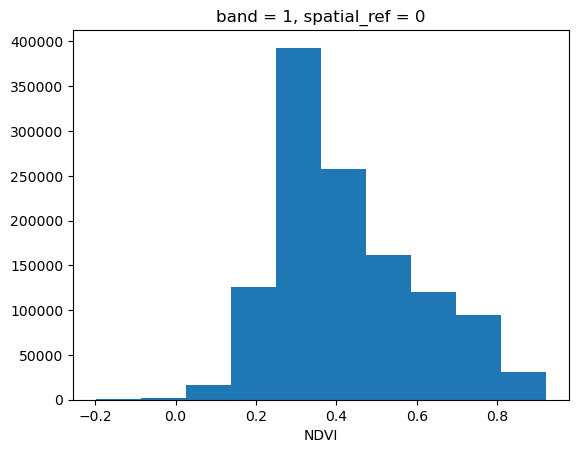

In [24]:
# Generate histogram of NDVI
ndvi_ds.NDVI.plot()

In [26]:
import matplotlib.pyplot as plt

# Calculate the change in NDVI pre and post fire
dndvi_da = (ndvi_ds
    .sel(date = '2022')
    .mean('date')
    .NDVI
- ndvi_ds
    .sel(date = '2012')
    .mean('date')
    .NDVI
)

In [63]:
# Check coordinate reference system of both datasets before plotting
print(sanjose_gdf.crs)
print(dndvi_da.crs)

EPSG:4326


AttributeError: 'DataArray' object has no attribute 'crs'

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

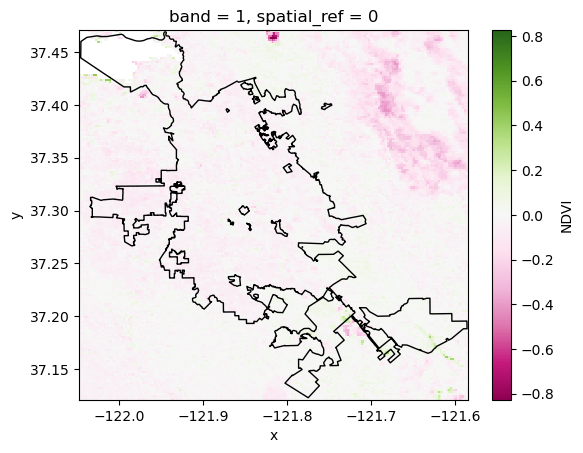

In [64]:
# Plot with matplotlib
dndvi_da.plot(cmap=plt.colormaps['PiYG'])
sanjose_gdf.plot(facecolor='none', ax=plt.gca())

In [54]:
# Swap the coordinates of sanjose_gdf to match dndvi_da
sanjose_gdf_swapped = sanjose_gdf.set_geometry(sanjose_gdf.geometry.to_crs(epsg=4326))

dndvi_plot = dndvi_da.hvplot(cmap='PiYG')

sanjose_plot = sanjose_gdf_swapped.hvplot(geo=True, fill_color = "none", line_color='black', alpha=0.9)

final_plot = dndvi_plot + sanjose_plot

# Display plot with San Jose boundary overlaid on NDVI
final_plot
# * camp_gdf.hvplot(facecolor='none', edgecolor = "darkorange", linewidth = 2)

/opt/conda/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/opt/conda/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(


:Layout
   .Image.I    :Image   [y,x]   (NDVI)
   .Polygons.I :Polygons   [Longitude,Latitude]

# Did the NDVI drop more inside the city limits than nearby areas?

In [55]:
# Get the area outside the city boundary
out_gdf = gpd.GeoDataFrame(geometry=sanjose_gdf.envelope).overlay(
    sanjose_gdf, how="difference"
)
out_gdf

,geometry
0,"MULTIPOLYGON (((-122.04607 37.12272, -122.0460..."



&#128187; **YOUR TASK:** Clip your DataArray to the boundaries for both inside and outside the reservation. You will need to replace the `GeoDataFrame` name with your own. Check out the [lesson on clipping data with the `rioxarray` library in the textbook](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/).

> **GOTCHA ALERT:** It's important to use `from_disk=True` when clipping large arrays like this. It allows the computer to use less valuable memory resources when clipping - you will probably find that otherwise the cell below crashes the kernel

In [57]:
ndvi_sanjose_ds = ndvi_ds.rio.clip(sanjose_gdf.geometry)
ndvi_outside_ds = ndvi_ds.rio.clip(out_gdf.geometry)

&#128187; **YOUR TASK:** Practice chaining `xarray` methods! For **both inside and outside** the Camp fire boundary:
  1. Group the data by year using
  2. Take the mean. You always need to tell reducing methods in `xarray` what dimensions you want to reduce. When you want to summarize data across **all** dimensions (except the group dimension(s)), you can use the `...` syntax, e.g. `.mean(...)` as a shorthand.
  3. Select the NDVI variable
  4. Convert to a `DataFrame` using the `to_dataframe()` method
  5. Call **both** of your `DataFrame`s at the end of the cell for testing, e.g.
     ```python
     inside_df, outside_df
     ```

> **GOTCHA ALERT:** the DateIndex in pandas is a little different from the Datetime Dimension in xarray. You will need to use the `.dt.year` syntax to access information about the year, not just `.year`.

In [59]:
# Calculate the mean NDVI per year
ndvi_sanjose_df = (
    ndvi_sanjose_ds
    .groupby(ndvi_sanjose_ds.date.dt.year)
    .mean(...)
    # ... means take the mean by every variable
    # that is not a grouping variable
    .NDVI
    .to_dataframe()[["NDVI"]])
ndvi_outside_df = (
    ndvi_outside_ds
    .groupby(ndvi_outside_ds.date.dt.year)
    .mean(...)
    # ... means take the mean by every variable
    # that is not a grouping variable
    .NDVI
    .to_dataframe()[["NDVI"]])
ndvi_sanjose_df, ndvi_outside_df


(          NDVI
 year          
 2012  0.323291
 2013  0.330175
 2014  0.310622
 2015  0.306544
 2016  0.313752
 2017  0.319050
 2018  0.311588
 2019  0.330538
 2020  0.316916
 2021  0.304515
 2022  0.299192,
           NDVI
 year          
 2012  0.477988
 2013  0.480093
 2014  0.460221
 2015  0.472924
 2016  0.476541
 2017  0.474574
 2018  0.474207
 2019  0.503266
 2020  0.469537
 2021  0.440626
 2022  0.444641)

&#128187; YOUR TASK:
  1. Take the difference between outside and inside the Reservation
     > GOTCHA ALERT: You may need to select the NDVI columns of your inside/outside `DataFrame`s in order to subtract effectively
  2. Save it as a new column in your `DataFrame`
  3. Plot the difference. What do you observe? Don't forget to write a **headline and description** of your plot!

&#127798; For an extra challenge, add a vertical line showing when the fire occurred. Note that unfortunately you will need to convert the date to a decimal of a year. You may find the pandas datetime method `.toordinal()` useful.


## Change in NDVI in San Jose from 2012 to 2022

In [62]:
(ndvi_sanjose_df).hvplot(
    xlabel='year', ylabel='dNDVI',
    title='Change in NDVI inside the San Jose city limits from 2012-2022'
)

:Curve   [year]   (NDVI)

In [61]:
(ndvi_sanjose_df - ndvi_outside_df).hvplot(
    xlabel='year', ylabel='dNDVI',
    title='Difference in NDVI between inside and outside the San Jose city limits'
)

:Curve   [year]   (NDVI)

**Vegetation productivity dropped after the Camp Fire in 2018, but has nearly recovered 3 years after the fire**

Peak greenness NDVI dropped 0.15 inside the boundary of the Camp Fire. However, NDVI does not allow us to distinguish between regrowth of forest vegetation or conversion of forest to shrubland or grassland. It is possible that the forest will take longer to recover, or may never recover.

In [3]:
%%capture
%%bash
jupyter nbconvert sanjose_urbanforest.ipynb --to html --no-input